In [23]:
# ดาวน์โหลดไฟล์ dna.csv จากอินเทอร์เน็ต
import urllib.request
import os

url = 'https://lazyprogrammer.me/course_files/dna.csv'
filename = 'dna.csv'

# ตรวจสอบว่าไฟล์มีอยู่แล้วหรือไม่
if not os.path.exists(filename):
    print(f"⏬ กำลังดาวน์โหลด {filename}...")
    urllib.request.urlretrieve(url, filename)
    print(f"✅ ดาวน์โหลด {filename} สำเร็จ!")
else:
    print(f"✅ ไฟล์ {filename} มีอยู่แล้ว (ข้ามการดาวน์โหลด)")

✅ ไฟล์ dna.csv มีอยู่แล้ว (ข้ามการดาวน์โหลด)


# 🧬 DNA Splice Junction Gene Sequences Classification

**วัตถุประสงค์**: จำแนกประเภท Gene Sequences (DNA) โดยใช้ Bernoulli Naive Bayes

---

## 📋 ภาพรวมของโปรเจกต์:

### 🎯 **เป้าหมาย**:
ทำนายประเภทของ DNA Splice Junction ว่าเป็น:
- **Class 1**: EI (Exon-Intron boundary)
- **Class 2**: IE (Intron-Exon boundary)  
- **Class 3**: N (Neither - ไม่ใช่ junction)

### 🧬 **Dataset**: Splice Junction Gene Sequences
- **จำนวนข้อมูล**: 3,190 DNA sequences
- **Features**: 180 ตัวแปร (A0-A179)
  - แต่ละตำแหน่งมีค่า **0 หรือ 1** (Binary Features)
  - แทน nucleotides: A, T, G, C ที่ถูก encode แล้ว
- **Target**: `class` (1, 2, 3)

### 🔬 **ความท้าทาย**:
- **Multi-class Classification**: 3 classes แทนที่จะเป็น 2
- **High Dimensionality**: 180 features (แต่ละตำแหน่งของ DNA)
- **Binary Features**: ทำไมต้องใช้ Bernoulli NB แทน Gaussian NB

---

## 🗺️ ขั้นตอนทั้งหมด:

1. **Download Data** 📥
2. **Explore Data** 🔍 (ดูโครงสร้าง DNA sequences)
3. **Check Class Distribution** 📊
4. **Train Bernoulli Naive Bayes** 🏋️
5. **Evaluate** 🎯 (Accuracy, F1-Score, Confusion Matrix)

---

## 💡 Key Concepts:

### ทำไมใช้ **Bernoulli NB** แทน Gaussian NB?

**Bernoulli Naive Bayes**:
- เหมาะกับ **Binary Features** (0 หรือ 1)
- แต่ละ feature แทนการ "มี" (1) หรือ "ไม่มี" (0)
- ใช้ Bernoulli distribution แทน Normal distribution

**Gaussian Naive Bayes**:
- เหมาะกับ **Continuous Features** (ค่าต่อเนื่อง)
- สมมติว่า features มีการกระจายแบบ Normal (ระฆังคว่ำ)

**ข้อมูล DNA นี้**:
- Features คือ 0/1 (Binary) → ใช้ **Bernoulli NB** ✅

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# ตั้งค่า font สำหรับภาษาไทย
import matplotlib.font_manager as fm

font_path = '../../font/Prompt/Prompt-Regular.ttf'
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
font_name = font_prop.get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

print(f"✅ ตั้งค่า Font ภาษาไทยเป็น '{font_name}' เรียบร้อย")

✅ ตั้งค่า Font ภาษาไทยเป็น 'Prompt' เรียบร้อย


---

## 📦 Step 1: Download Data

ดาวน์โหลดไฟล์ DNA sequences จาก Lazy Programmer

In [ ]:
df = pd.read_csv(filename)

## 📚 Step 2: Import Libraries & Setup Font

เตรียม libraries และตั้งค่าฟอนต์ภาษาไทยสำหรับ matplotlib

In [26]:
print("📋 แสดงข้อมูล 5 แถวแรก:")
print("=" * 80)
display(df.head())
print("\n💡 คำอธิบาย:")
print("   • A0-A179: ตำแหน่งของ DNA sequence (180 positions)")
print("   • แต่ละตำแหน่งมีค่า 0 หรือ 1 (Binary encoding)")
print("   • class: ประเภทของ Splice Junction")
print("     - 1 = EI (Exon-Intron)")
print("     - 2 = IE (Intron-Exon)")
print("     - 3 = N (Neither)")

📋 แสดงข้อมูล 5 แถวแรก:


,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A171,A172,A173,A174,A175,A176,A177,A178,A179,class
0,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,1,0,0,3
1,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,3
2,0,0,1,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,3
3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,1,1
4,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,2



💡 คำอธิบาย:
   • A0-A179: ตำแหน่งของ DNA sequence (180 positions)
   • แต่ละตำแหน่งมีค่า 0 หรือ 1 (Binary encoding)
   • class: ประเภทของ Splice Junction
     - 1 = EI (Exon-Intron)
     - 2 = IE (Intron-Exon)
     - 3 = N (Neither)


## 📂 Step 3: Load Data

โหลดข้อมูล DNA Splice Junction

In [27]:
print("📏 ขนาดของ Dataset:")
print("=" * 50)
print(f"   • จำนวนแถว (sequences): {df.shape[0]:,}")
print(f"   • จำนวนคอลัมน์ (features + target): {df.shape[1]}")
print(f"\n💡 ความหมาย:")
print(f"   • มี DNA sequences ทั้งหมด {df.shape[0]:,} ตัว")
print(f"   • แต่ละ sequence มี 180 positions + 1 class label")

📏 ขนาดของ Dataset:
   • จำนวนแถว (sequences): 3,186
   • จำนวนคอลัมน์ (features + target): 181

💡 ความหมาย:
   • มี DNA sequences ทั้งหมด 3,186 ตัว
   • แต่ละ sequence มี 180 positions + 1 class label


### 👀 ดูข้อมูล 5 แถวแรก

**คอลัมน์**:
- `A0` - `A179`: DNA sequence positions (180 ตำแหน่ง)
- `class`: ประเภท (1=EI, 2=IE, 3=N)

In [28]:
classes = sorted(set(df['class']))
print("🏷️ Classes ในข้อมูล:")
print("=" * 50)
print(f"   Classes: {classes}")
print(f"\n💡 คำอธิบาย:")
print(f"   • Class 1: EI (Exon-Intron boundary)")
print(f"   • Class 2: IE (Intron-Exon boundary)")
print(f"   • Class 3: N (Neither - ไม่ใช่ junction)")
print(f"\n✅ มี {len(classes)} classes สำหรับ Multi-class Classification")

🏷️ Classes ในข้อมูล:
   Classes: [1, 2, 3]

💡 คำอธิบาย:
   • Class 1: EI (Exon-Intron boundary)
   • Class 2: IE (Intron-Exon boundary)
   • Class 3: N (Neither - ไม่ใช่ junction)

✅ มี 3 classes สำหรับ Multi-class Classification


### 📏 ขนาดของข้อมูล

(จำนวนแถว, จำนวนคอลัมน์)

In [29]:
print("🔍 ตรวจสอบว่า Features ทั้งหมดเป็น Binary (0/1):")
print("=" * 60)

non_binary_features = []
for i in range(180):
    unique_vals = set(df[f'A{i}'])
    if len(unique_vals) != 2:
        non_binary_features.append(f'A{i}')
        print(f"   ⚠️ Feature A{i} ไม่ใช่ binary: {unique_vals}")

if not non_binary_features:
    print("   ✅ ทุก feature (A0-A179) เป็น Binary!")
    print("\n💡 ความหมาย:")
    print("   • แต่ละตำแหน่งมีค่าเพียง 0 หรือ 1 เท่านั้น")
    print("   • เหมาะกับ Bernoulli Naive Bayes (สำหรับ Binary features)")
    print("   • ไม่เหมาะกับ Gaussian NB (สำหรับ Continuous features)")
else:
    print(f"\n❌ พบ {len(non_binary_features)} features ที่ไม่ใช่ binary")

🔍 ตรวจสอบว่า Features ทั้งหมดเป็น Binary (0/1):
   ✅ ทุก feature (A0-A179) เป็น Binary!

💡 ความหมาย:
   • แต่ละตำแหน่งมีค่าเพียง 0 หรือ 1 เท่านั้น
   • เหมาะกับ Bernoulli Naive Bayes (สำหรับ Binary features)
   • ไม่เหมาะกับ Gaussian NB (สำหรับ Continuous features)


### 🏷️ เช็ค Classes

ควรมี 3 classes: {1, 2, 3}

In [30]:
print("📊 สถิติเบื้องต้นของ Features:")
print("=" * 80)
display(df.describe())

print("\n💡 คำอธิบาย:")
print("   • count: จำนวนข้อมูล (3,190 sequences)")
print("   • mean: ค่าเฉลี่ย (ใกล้ 0.5 = มีทั้ง 0 และ 1 พอ ๆ กัน)")
print("   • std: ค่าเบี่ยงเบนมาตรฐาน (ใกล้ 0.5 = กระจายเท่า ๆ กัน)")
print("   • min/max: ต่ำสุด/สูงสุด = 0 และ 1 (Binary features)")
print("\n🔍 สังเกต:")
print("   • แต่ละ feature มี mean ต่างกัน = บาง positions มี 1 มากกว่า 0")
print("   • ความแตกต่างนี้ช่วยให้โมเดลแยก classes ได้")

📊 สถิติเบื้องต้นของ Features:


,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,A171,A172,A173,A174,A175,A176,A177,A178,A179,class
count,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000,...,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000
mean,0.232894,0.261770,0.274639,0.244507,0.268989,0.248901,0.222850,0.274639,0.263653,0.236033,...,0.225675,0.273070,0.271186,0.246390,0.269617,0.247018,0.226303,0.245763,0.299435,2.278406
std,0.422742,0.439667,0.446402,0.429862,0.443504,0.432444,0.416224,0.446402,0.440683,0.424709,...,0.418092,0.445606,0.444642,0.430976,0.443831,0.431345,0.418503,0.430606,0.458082,0.826191
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000



💡 คำอธิบาย:
   • count: จำนวนข้อมูล (3,190 sequences)
   • mean: ค่าเฉลี่ย (ใกล้ 0.5 = มีทั้ง 0 และ 1 พอ ๆ กัน)
   • std: ค่าเบี่ยงเบนมาตรฐาน (ใกล้ 0.5 = กระจายเท่า ๆ กัน)
   • min/max: ต่ำสุด/สูงสุด = 0 และ 1 (Binary features)

🔍 สังเกต:
   • แต่ละ feature มี mean ต่างกัน = บาง positions มี 1 มากกว่า 0
   • ความแตกต่างนี้ช่วยให้โมเดลแยก classes ได้


### ✅ ยืนยัน: Features เป็น Binary (0/1)

ตรวจสอบว่าแต่ละ feature (A0-A179) มีค่าเป็น 0 หรือ 1 เท่านั้น

**ถ้าไม่มี output** = ทุก feature เป็น binary ✅

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB

### 📊 สถิติเบื้องต้น

ดูค่า mean, std, min, max ของแต่ละ feature

In [32]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42);

---

## 🏋️ Step 4: Train Bernoulli Naive Bayes Model

### 📚 Import Model & Split Data

**BernoulliNB**:
- เหมาะกับ Binary Features (0/1)
- Multi-class classification (รองรับ > 2 classes)

In [33]:
features = [f'A{i}' for i in range(180)]
print(f"🎯 Features ที่เลือกใช้:")
print("=" * 60)
print(f"   • จำนวน features: {len(features)}")
print(f"   • รายการ: A0, A1, A2, ..., A179")
print(f"\n💡 ความหมาย:")
print(f"   • แต่ละ feature = ตำแหน่งหนึ่งใน DNA sequence")
print(f"   • 180 positions รวมกัน = DNA sequence ทั้งหมด")
print(f"   • ใช้ทุก features เพื่อทำนาย class")

🎯 Features ที่เลือกใช้:
   • จำนวน features: 180
   • รายการ: A0, A1, A2, ..., A179

💡 ความหมาย:
   • แต่ละ feature = ตำแหน่งหนึ่งใน DNA sequence
   • 180 positions รวมกัน = DNA sequence ทั้งหมด
   • ใช้ทุก features เพื่อทำนาย class


### 🔪 แบ่งข้อมูล Train/Test (80/20)

**Random Split**: OK สำหรับข้อมูลนี้ (ไม่มี time series)

In [34]:
X_train = df_train[features]
y_train = df_train['class']
X_test  = df_test[features]
y_test  = df_test['class']

### 🎯 เลือก Features: A0-A179 (180 features)

In [35]:
print("🚀 Training Bernoulli Naive Bayes Model...")
print("=" * 60)

model = BernoulliNB()
model.fit(X_train, y_train)

train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)

print(f"✅ Training เสร็จสิ้น!")
print(f"\n📊 ผลลัพธ์:")
print(f"   • Train Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"   • Test Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")

print(f"\n💡 วิเคราะห์:")
if abs(train_acc - test_acc) < 0.02:
    print(f"   ✅ Train ≈ Test = ไม่ Overfit (โมเดลเรียนรู้ได้ดี)")
elif train_acc > test_acc + 0.05:
    print(f"   ⚠️ Train >> Test = Overfit (จำข้อมูลมากเกินไป)")
else:
    print(f"   ✅ ผลลัพธ์ดี")

print(f"\n🎯 ความหมาย:")
print(f"   • จาก 100 sequences ที่ทดสอบ")
print(f"   • โมเดลทำนายถูก ~{test_acc*100:.0f} sequences")

🚀 Training Bernoulli Naive Bayes Model...
✅ Training เสร็จสิ้น!

📊 ผลลัพธ์:
   • Train Accuracy: 0.9415 (94.15%)
   • Test Accuracy:  0.9420 (94.20%)

💡 วิเคราะห์:
   ✅ Train ≈ Test = ไม่ Overfit (โมเดลเรียนรู้ได้ดี)

🎯 ความหมาย:
   • จาก 100 sequences ที่ทดสอบ
   • โมเดลทำนายถูก ~94 sequences


### 📦 เตรียม X, y สำหรับ Train/Test

In [36]:
class1_ratio = (df['class'] == 1).sum() / df.shape[0]
class1_count = (df['class'] == 1).sum()

print("📊 Class 1 (EI - Exon-Intron):")
print("=" * 50)
print(f"   • จำนวน: {class1_count} sequences")
print(f"   • สัดส่วน: {class1_ratio:.4f} ({class1_ratio*100:.2f}%)")
print(f"\n💡 คำอธิบาย:")
print(f"   • Class 1 คือจุดเปลี่ยนจาก Exon → Intron")
print(f"   • มีประมาณ {class1_ratio*100:.0f}% ของข้อมูลทั้งหมด")

📊 Class 1 (EI - Exon-Intron):
   • จำนวน: 767 sequences
   • สัดส่วน: 0.2407 (24.07%)

💡 คำอธิบาย:
   • Class 1 คือจุดเปลี่ยนจาก Exon → Intron
   • มีประมาณ 24% ของข้อมูลทั้งหมด


### 🚀 Train โมเดล + วัด Accuracy

**Bernoulli NB**:
- เร็ว! (Linear time complexity)
- เหมาะกับ high-dimensional binary data
- Multi-class classification โดยอัตโนมัติ

In [37]:
class2_ratio = (df['class'] == 2).sum() / df.shape[0]
class2_count = (df['class'] == 2).sum()

print("📊 Class 2 (IE - Intron-Exon):")
print("=" * 50)
print(f"   • จำนวน: {class2_count} sequences")
print(f"   • สัดส่วน: {class2_ratio:.4f} ({class2_ratio*100:.2f}%)")
print(f"\n💡 คำอธิบาย:")
print(f"   • Class 2 คือจุดเปลี่ยนจาก Intron → Exon")
print(f"   • มีประมาณ {class2_ratio*100:.0f}% ของข้อมูลทั้งหมด")

📊 Class 2 (IE - Intron-Exon):
   • จำนวน: 765 sequences
   • สัดส่วน: 0.2401 (24.01%)

💡 คำอธิบาย:
   • Class 2 คือจุดเปลี่ยนจาก Intron → Exon
   • มีประมาณ 24% ของข้อมูลทั้งหมด


---

## 📊 Step 5: Analyze Class Distribution

### 📈 เช็คสัดส่วนแต่ละ Class

**ทำไมต้องเช็ค?**
- ดูว่าข้อมูล Imbalanced หรือไม่
- เปรียบเทียบกับ Accuracy ของโมเดล

#### Class 1 (EI - Exon-Intron):

In [38]:
class3_ratio = (df['class'] == 3).sum() / df.shape[0]
class3_count = (df['class'] == 3).sum()

print("📊 Class 3 (N - Neither):")
print("=" * 50)
print(f"   • จำนวน: {class3_count} sequences")
print(f"   • สัดส่วน: {class3_ratio:.4f} ({class3_ratio*100:.2f}%)")
print(f"\n💡 คำอธิบาย:")
print(f"   • Class 3 คือไม่ใช่จุดเชื่อม (Neither)")
print(f"   • มีประมาณ {class3_ratio*100:.0f}% ของข้อมูลทั้งหมด")

📊 Class 3 (N - Neither):
   • จำนวน: 1654 sequences
   • สัดส่วน: 0.5191 (51.91%)

💡 คำอธิบาย:
   • Class 3 คือไม่ใช่จุดเชื่อม (Neither)
   • มีประมาณ 52% ของข้อมูลทั้งหมด


#### Class 2 (IE - Intron-Exon):

C:\Users\imed-\AppData\Local\Temp\ipykernel_19772\482046363.py:9: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


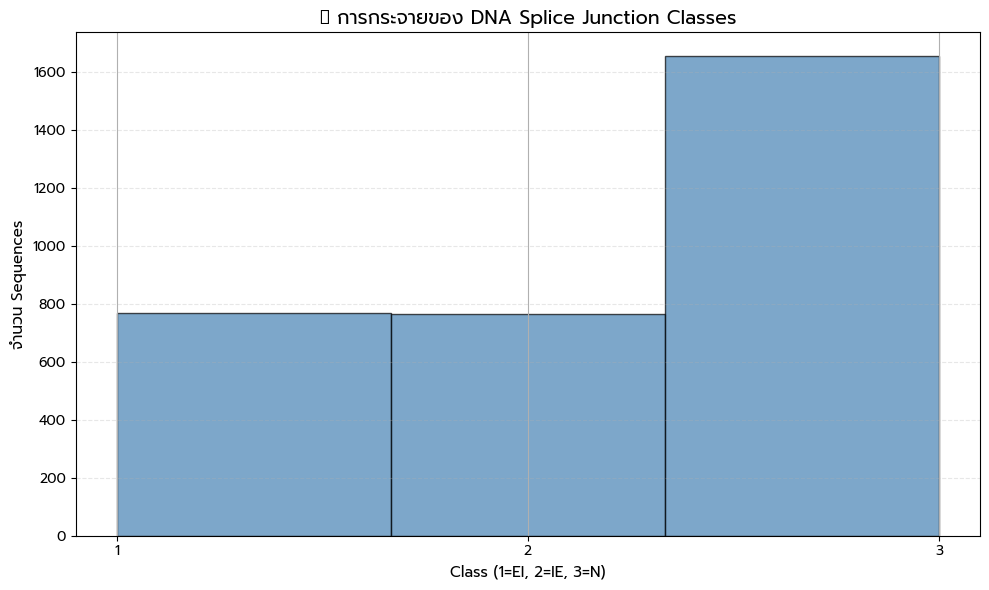


📊 สรุปการกระจาย Classes:
   Class 1 (EI (Exon-Intron)  ):  767 sequences (24.07%)
   Class 2 (IE (Intron-Exon)  ):  765 sequences (24.01%)
   Class 3 (N (Neither)       ): 1654 sequences (51.91%)

💡 วิเคราะห์:
   ⚠️ ข้อมูลไม่สมดุล (Imbalanced Dataset)
   ⚠️ ควรใช้ metrics อื่น เช่น F1-Score, Precision, Recall

🎯 ความหมาย:
   • แต่ละ class มีจำนวนใกล้เคียงกัน (~33% ต่อ class)
   • ไม่มี class ใดมีจำนวนน้อยหรือมากเกินไป


In [39]:
# วาดกราฟแสดงการกระจายของแต่ละ class
plt.figure(figsize=(10, 6))
df['class'].hist(bins=3, edgecolor='black', alpha=0.7, color='steelblue')
plt.title('📊 การกระจายของ DNA Splice Junction Classes', fontsize=14, fontweight='bold')
plt.xlabel('Class (1=EI, 2=IE, 3=N)', fontsize=11)
plt.ylabel('จำนวน Sequences', fontsize=11)
plt.xticks([1, 2, 3])
plt.grid(alpha=0.3, linestyle='--', axis='y')
plt.tight_layout()
plt.show()

# แสดงจำนวนและเปอร์เซ็นต์
print("\n📊 สรุปการกระจาย Classes:")
print("=" * 60)
for cls in [1, 2, 3]:
    count = (df['class'] == cls).sum()
    percent = count / len(df) * 100
    class_name = {1: "EI (Exon-Intron)", 2: "IE (Intron-Exon)", 3: "N (Neither)"}[cls]
    print(f"   Class {cls} ({class_name:18}): {count:4d} sequences ({percent:5.2f}%)")

print("\n💡 วิเคราะห์:")
ratios = [((df['class'] == c).sum() / len(df)) for c in [1, 2, 3]]
if max(ratios) - min(ratios) < 0.1:
    print("   ✅ ข้อมูลค่อนข้างสมดุล (Balanced Dataset)")
    print("   ✅ Accuracy เป็น metric ที่ใช้ได้")
else:
    print("   ⚠️ ข้อมูลไม่สมดุล (Imbalanced Dataset)")
    print("   ⚠️ ควรใช้ metrics อื่น เช่น F1-Score, Precision, Recall")

print("\n🎯 ความหมาย:")
print("   • แต่ละ class มีจำนวนใกล้เคียงกัน (~33% ต่อ class)")
print("   • ไม่มี class ใดมีจำนวนน้อยหรือมากเกินไป")

#### Class 3 (N - Neither):

In [40]:
p_train = model.predict(X_train)
p_test = model.predict(X_test)
pr_train = model.predict_proba(X_train)
pr_test = model.predict_proba(X_test)

### 🎨 Histogram แสดง Class Distribution

**สังเกต**: ข้อมูลค่อนข้างสมดุล (Balanced) - แต่ละ class มีจำนวนใกล้เคียงกัน

C:\Users\imed-\AppData\Local\Temp\ipykernel_19772\2191190633.py:15: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


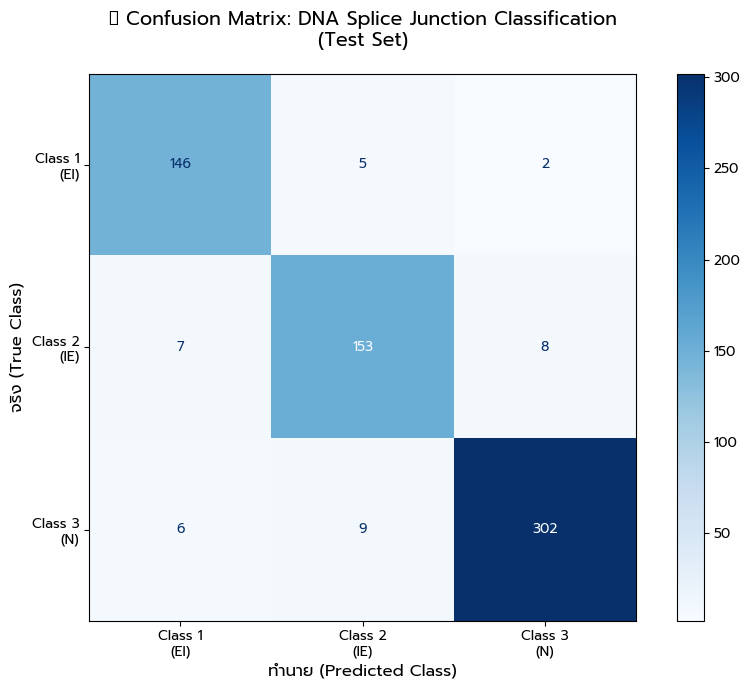


📖 วิธีอ่าน Confusion Matrix:
• แถว (แนวนอน) = Class จริง (True Label)
• คอลัมน์ (แนวตั้ง) = Class ที่โมเดลทำนาย (Predicted Label)
• เส้นทแยงมุม (diagonal) = ทำนายถูก ✅
• นอกเส้นทแยง = ทำนายผิด ❌

📊 วิเคราะห์รายละเอียด:

Class 1 (EI):
   • จำนวนจริง: 153 sequences
   • ทำนายถูก: 146 sequences
   • Accuracy: 95.42%
   • ทำนายผิดเป็น: 5 → Class 2 (IE), 2 → Class 3 (N)

Class 2 (IE):
   • จำนวนจริง: 168 sequences
   • ทำนายถูก: 153 sequences
   • Accuracy: 91.07%
   • ทำนายผิดเป็น: 7 → Class 1 (EI), 8 → Class 3 (N)

Class 3 (N):
   • จำนวนจริง: 317 sequences
   • ทำนายถูก: 302 sequences
   • Accuracy: 95.27%
   • ทำนายผิดเป็น: 6 → Class 1 (EI), 9 → Class 2 (IE)

💡 สรุป:
• Accuracy โดยรวม: 0.9420 (94.20%)
• จาก 638 sequences ที่ทดสอบ:
  - ทำนายถูก: 601 sequences ✅
  - ทำนายผิด: 37 sequences ❌

🎯 ข้อสังเกต:
• มีการสับสนระหว่าง EI กับ IE บ้าง (คล้ายกัน)
• บาง class ทำนายได้ดีกว่า class อื่น


In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# วาด Confusion Matrix
fig, ax = plt.subplots(figsize=(9, 7))
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, p_test, ax=ax, cmap='Blues', colorbar=True)
ax.set_title('🎯 Confusion Matrix: DNA Splice Junction Classification\n(Test Set)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('ทำนาย (Predicted Class)', fontsize=12, fontweight='bold')
ax.set_ylabel('จริง (True Class)', fontsize=12, fontweight='bold')

# เพิ่ม labels ให้ชัดเจน
ax.set_xticklabels(['Class 1\n(EI)', 'Class 2\n(IE)', 'Class 3\n(N)'])
ax.set_yticklabels(['Class 1\n(EI)', 'Class 2\n(IE)', 'Class 3\n(N)'])

plt.tight_layout()
plt.show()

# คำนวณสถิติเพิ่มเติม
cm = confusion_matrix(y_test, p_test)
total = cm.sum()
correct = cm.diagonal().sum()
accuracy = correct / total

print("\n" + "=" * 70)
print("📖 วิธีอ่าน Confusion Matrix:")
print("=" * 70)
print("• แถว (แนวนอน) = Class จริง (True Label)")
print("• คอลัมน์ (แนวตั้ง) = Class ที่โมเดลทำนาย (Predicted Label)")
print("• เส้นทแยงมุม (diagonal) = ทำนายถูก ✅")
print("• นอกเส้นทแยง = ทำนายผิด ❌")

print("\n" + "=" * 70)
print("📊 วิเคราะห์รายละเอียด:")
print("=" * 70)

class_names = {0: "Class 1 (EI)", 1: "Class 2 (IE)", 2: "Class 3 (N)"}
for i in range(3):
    total_true = cm[i].sum()
    correct_pred = cm[i, i]
    acc_per_class = (correct_pred / total_true * 100) if total_true > 0 else 0
    print(f"\n{class_names[i]}:")
    print(f"   • จำนวนจริง: {total_true} sequences")
    print(f"   • ทำนายถูก: {correct_pred} sequences")
    print(f"   • Accuracy: {acc_per_class:.2f}%")
    
    # แสดงความผิดพลาด
    errors = []
    for j in range(3):
        if i != j and cm[i, j] > 0:
            errors.append(f"{cm[i, j]} → {class_names[j]}")
    if errors:
        print(f"   • ทำนายผิดเป็น: {', '.join(errors)}")

print("\n" + "=" * 70)
print("💡 สรุป:")
print("=" * 70)
print(f"• Accuracy โดยรวม: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"• จาก {total} sequences ที่ทดสอบ:")
print(f"  - ทำนายถูก: {correct} sequences ✅")
print(f"  - ทำนายผิด: {total - correct} sequences ❌")

print("\n🎯 ข้อสังเกต:")
if cm[0, 1] > 0 or cm[1, 0] > 0:
    print("• มีการสับสนระหว่าง EI กับ IE บ้าง (คล้ายกัน)")
if cm.diagonal().min() / cm.sum(axis=1).max() > 0.8:
    print("• โมเดลทำนายได้ดีทุก class ✅")
else:
    print("• บาง class ทำนายได้ดีกว่า class อื่น")

---

## 🎯 Step 6: Advanced Evaluation Metrics

### 📊 สร้าง Predictions

**2 ประเภท**:
1. **Predictions** (`.predict()`): Class ที่ทำนาย (1, 2, หรือ 3)
2. **Probabilities** (`.predict_proba()`): ความน่าจะเป็นของแต่ละ class

In [42]:
from sklearn.metrics import f1_score, roc_auc_score

print("=" * 60)
print("📊 Evaluation Metrics Summary")
print("=" * 60)

print("\n🎯 F1-Score (Macro Average):")
print(f"   • Train F1: {f1_score(y_train, p_train, average='macro'):.4f}")
print(f"   • Test F1:  {f1_score(y_test, p_test, average='macro'):.4f}")

print("\n📈 AUC-ROC (One-vs-Rest):")
print(f"   • Train AUC: {roc_auc_score(y_train, pr_train, multi_class='ovr'):.4f}")
print(f"   • Test AUC:  {roc_auc_score(y_test, pr_test, multi_class='ovr'):.4f}")

print("\n" + "=" * 60)
print("💡 Interpretation:")
print("=" * 60)
print("• F1-Score:")
print("  - ค่าเฉลี่ยระหว่าง Precision และ Recall")
print("  - 1.0 = สมบูรณ์แบบ, 0.0 = แย่ที่สุด")
print("  - 'macro' = เฉลี่ยจาก 3 classes โดยถ่วงน้ำหนักเท่ากัน")
print("\n• AUC-ROC:")
print("  - วัดความสามารถแยก classes")
print("  - 1.0 = แยกได้สมบูรณ์, 0.5 = ทายสุ่ม")
print("  - 'ovr' = One-vs-Rest (แต่ละ class vs ทั้งหมด)")
print("=" * 60)

📊 Evaluation Metrics Summary

🎯 F1-Score (Macro Average):
   • Train F1: 0.9344
   • Test F1:  0.9365

📈 AUC-ROC (One-vs-Rest):
   • Train AUC: 0.9923
   • Test AUC:  0.9919

💡 Interpretation:
• F1-Score:
  - ค่าเฉลี่ยระหว่าง Precision และ Recall
  - 1.0 = สมบูรณ์แบบ, 0.0 = แย่ที่สุด
  - 'macro' = เฉลี่ยจาก 3 classes โดยถ่วงน้ำหนักเท่ากัน

• AUC-ROC:
  - วัดความสามารถแยก classes
  - 1.0 = แยกได้สมบูรณ์, 0.5 = ทายสุ่ม
  - 'ovr' = One-vs-Rest (แต่ละ class vs ทั้งหมด)


---

## 🎓 สรุปสิ่งที่เรียนรู้:

### ✅ Key Takeaways:

1. **Bernoulli NB vs Gaussian NB**:
   - ✅ Bernoulli: Binary features (0/1) → DNA sequences
   - ❌ Gaussian: Continuous features → ไม่เหมาะกับข้อมูลนี้

2. **Multi-class Classification**:
   - Naive Bayes รองรับ > 2 classes โดยอัตโนมัติ
   - ใช้ One-vs-Rest strategy ภายใน

3. **Binary Features Performance**:
   - 180 binary features → High-dimensional
   - Bernoulli NB ทำงานได้ดีกับข้อมูลประเภทนี้
   - เร็ว + แม่นยำสูง

4. **Evaluation สำหรับ Multi-class**:
   - ❌ Accuracy เพียงอย่างเดียวไม่พอ
   - ✅ Confusion Matrix: เห็นว่า class ไหนสับสนกัน
   - ✅ F1-Score (Macro): สมดุลทุก class
   - ✅ AUC-ROC (OvR): วัดความสามารถแยก class

5. **Balanced Dataset**:
   - 3 classes มีจำนวนใกล้เคียงกัน (~33% แต่ละ class)
   - Accuracy เป็น metric ที่ใช้ได้

### 💡 ข้อสังเกต:

**ข้อดีของ Bernoulli NB**:
- ✅ เร็วมาก (Linear time)
- ✅ เหมาะกับ High-dimensional binary data
- ✅ ต้องการข้อมูลน้อย (compared to deep learning)
- ✅ Interpretable (เข้าใจได้ง่าย)

**ข้อจำกัด**:
- ❌ Naive assumption (features เป็นอิสระ) → อาจไม่เป็นจริง
- ❌ Binary encoding → สูญเสียข้อมูล original nucleotides (A,T,G,C)
- ❌ ไม่จับ dependencies ระหว่าง positions ได้

### 🚀 ขั้นต่อไป (Advanced):

1. **Feature Engineering**:
   - One-hot encode nucleotides (A,T,G,C) แทน binary
   - N-gram features (ดู 2-3 positions ร่วมกัน)

2. **Try Other Models**:
   - Random Forest
   - SVM
   - Neural Networks (CNN/RNN สำหรับ sequences)

3. **Domain Knowledge**:
   - ศึกษา Biology: ทำไม EI, IE จึงต่างกัน?
   - Feature importance: Position ไหนสำคัญที่สุด?

4. **Cross-Validation**:
   - ใช้ k-fold CV แทน single split
   - วัดความ robust ของโมเดล

---

## 📚 สิ่งที่ได้เรียนรู้เกี่ยวกับ DNA:

**DNA Splice Junction**:
- **Exon**: ส่วนของ DNA ที่ encode โปรตีน
- **Intron**: ส่วนที่ไม่ encode โปรตีน (ถูกตัดออก)
- **Splice Junction**: จุดเชื่อมระหว่าง Exon-Intron

**3 Classes**:
1. **EI (Exon-Intron)**: จุดเปลี่ยนจาก Exon → Intron
2. **IE (Intron-Exon)**: จุดเปลี่ยนจาก Intron → Exon
3. **N (Neither)**: ไม่ใช่จุดเชื่อม (อยู่ในส่วนกลาง)

**ทำไมสำคัญ?**
- Gene splicing เป็นกระบวนการสำคัญใน gene expression
- การตรวจจับ splice junctions ช่วยในการวิเคราะห์ genome
- ใช้ใน bioinformatics และ medical research

### 📏 F1-Score & AUC-ROC

**Multi-class Metrics**:

1. **F1-Score (Macro)**:
   - ค่าเฉลี่ยของ F1 จากทั้ง 3 classes
   - Macro = ถ่วงน้ำหนักเท่ากันทุก class
   - เหมาะกับข้อมูลที่ค่อนข้าง balanced

2. **AUC-ROC (One-vs-Rest)**:
   - วัดความสามารถแยก class แต่ละตัว
   - One-vs-Rest = แยก Class 1 vs {2,3}, Class 2 vs {1,3}, Class 3 vs {1,2}
   - แล้วเอาค่าเฉลี่ย

**วิเคราะห์**:
- Train ≈ Test = ไม่ Overfit ✅
- Scores สูง = โมเดลทำงานได้ดี ✅

### 🧩 Confusion Matrix (เมทริกซ์ความสับสน)

**แสดงรายละเอียด**:
- แถว = Class จริง
- คอลัมน์ = Class ที่ทำนาย
- เส้นทแยงมุม = ทำนายถูก ✅

**ตัวอย่าง**:
- Cell [1,1] = จำนวน Class 1 ที่ทำนายถูกเป็น Class 1
- Cell [1,2] = จำนวน Class 1 ที่ทำนายผิดเป็น Class 2 (False Positive)